In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf
import pandas as pd
import numpy as np 


In [3]:
train_ds, test_ds = tfds.load('fashion_mnist', split=['train', 'test'], shuffle_files=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete702QGZ/fashion_mnist-train.tfrecord


  0%|          | 0/60000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete702QGZ/fashion_mnist-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


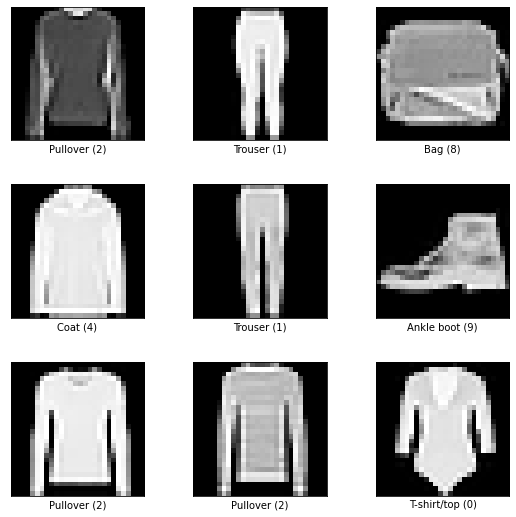

tfds.core.DatasetInfo(
    name='fashion_mnist',
    version=3.0.1,
    description='Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.',
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    = {Han Xiao and
                   Kashif Rasul and
                   Roland Vollgraf},
      title     = {Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning
                   Algorithms},
      journal   = {CoRR},
      volume

In [4]:
ds_mnist, info = tfds.load('fashion_mnist', split='train', with_info=True, as_supervised=True)
fig = tfds.show_examples(ds_mnist, info)
print(info)

In [5]:
@tf.autograph.experimental.do_not_convert
def prepare_fashion_data(ds):
    # reduce memory requirment and fit to frame 
    ds = ds.map(lambda img, target:(tf.cast(img, dtype=tf.float32), tf.cast(target, dtype=tf.int32)))
    # input normalization
    ds = ds.map(lambda img, target: ((img/128.)-1., target))
    # apply one_hot 
    ds = ds.map(lambda img, target: (img, tf.one_hot(target, depth=10)))
    ds = ds.cache()
    ds = ds.shuffle(100)
    ds = ds.batch(32)
    ds = ds.prefetch(64)
    return ds

In [6]:
train_ds = prepare_fashion_data(train_ds)
test_ds = prepare_fashion_data(test_ds)

In [7]:
from tensorflow.keras.layers import Dense

class CNN_Model(tf.keras.Model):
    
    def __init__(self):
        super(CNN_Model, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu')
        self.pool3 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)
        self.conv4 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu')
        self.conv5 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu')
        self.global_pool = tf.keras.layers.GlobalAvgPool2D()
        self.out = tf.keras.layers.Dense(10, activation='softmax')
   
    @tf.function
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.pool3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.global_pool(x)
        x = self.out(x)
        return x

In [8]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss

def test(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = tf.reduce_mean(test_loss_aggregator)
  test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [9]:

#For showcasing we only use a subset of the training and test data (generally use all of the available data!)
train_dataset = train_ds
test_dataset = test_ds

### Hyperparameters
num_epochs = 10
learning_rate = 0.1

# Initialize the model.
model = CNN_Model()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: SGD with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.SGD(learning_rate)

# Initialize lists for later visualization.
train_losses = []

test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs.
for epoch in range(num_epochs):
    print(f'Epoch: {str(epoch)} accuracy of {test_accuracies[epoch]}')
    #training (and checking in with training)
    epoch_loss_agg = []
    for input,target in train_dataset:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        epoch_loss_agg.append(train_loss)
    
    #track training loss
    train_losses.append(tf.reduce_mean(epoch_loss_agg))

    #testing, so we can track accuracy and test loss
    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch: 0 accuracy of 0.09994009584664537
Epoch: 1 accuracy of 0.7766573482428115
Epoch: 2 accuracy of 0.7992212460063898
Epoch: 3 accuracy of 0.8519369009584664
Epoch: 4 accuracy of 0.8664137380191693
Epoch: 5 accuracy of 0.8626198083067093
Epoch: 6 accuracy of 0.8811900958466453
Epoch: 7 accuracy of 0.8810902555910544
Epoch: 8 accuracy of 0.8963658146964856
Epoch: 9 accuracy of 0.8765974440894568


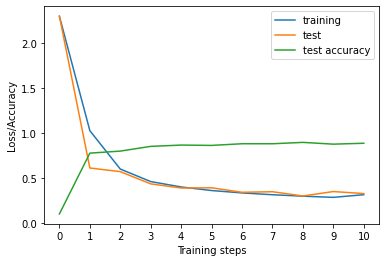

In [10]:
import matplotlib.pyplot as plt

x = range(11)
plt.figure()
plt.xticks(np.arange(min(x), max(x)+1, 1.0))
line1, = plt.plot(x, train_losses)
line2, = plt.plot(x, test_losses)
line3, = plt.plot(x, test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Loss/Accuracy")
plt.legend((line1,line2, line3),("training","test", "test accuracy"))
plt.show()